In [1]:
import os
from pathlib import Path
from datetime import datetime
import requests
import pandas as pd
from dotenv import load_dotenv
load_dotenv() 
API_KEY = os.getenv("ALPHA_VANTAGE_KEY")
SYMBOL  = "CME"  

assert API_KEY, "Missing ALPHA_VANTAGE_KEY in .env"
    
ROOT = Path("..").resolve()  
RAW  = ROOT / "data" / "raw"
RAW.mkdir(parents=True, exist_ok=True)

# ---------- request ----------
params = {
    "function": "TIME_SERIES_DAILY",    
    "symbol": SYMBOL,
    "outputsize": "compact",
    "apikey": API_KEY,
}

resp = requests.get("https://www.alphavantage.co/query", params=params, timeout=30)
resp.raise_for_status()
data = resp.json()

# Handle API errors / throttling messages
if "Error Message" in data:
    raise RuntimeError(f"Alpha Vantage error: {data['Error Message']}")
if "Note" in data:
    raise RuntimeError(f"Alpha Vantage notice (likely rate limit): {data['Note']}")

ts_key = "Time Series (Daily)"
assert ts_key in data, f"Unexpected response keys: {list(data.keys())}"

# ---------- normalize ----------
df_api = pd.DataFrame(data[ts_key]).T
df_api.index.name = "date"
df_api = df_api.rename(columns={
    "1. open": "open",
    "2. high": "high",
    "3. low":  "low",
    "4. close": "close",
    "5. volume": "volume",
})

# types + sort
num_cols = ["open", "high", "low", "close", "volume"]
df_api[num_cols] = df_api[num_cols].apply(pd.to_numeric, errors="coerce")
df_api = df_api.reset_index()
df_api["date"] = pd.to_datetime(df_api["date"])
df_api = df_api.sort_values("date").reset_index(drop=True)

# ---------- validate ----------
assert not df_api.empty, "API returned empty dataset — check symbol or connectivity"
assert set(num_cols).issubset(df_api.columns), f"Missing cols: {set(num_cols) - set(df_api.columns)}"

# ---------- save ----------
timestamp = datetime.now().strftime("%Y%m%d-%H%M")
out_path = RAW / f"api_alphavantage_{SYMBOL}_{timestamp}.csv"
df_api.to_csv(out_path, index=False)
print("Saved:", out_path.as_posix())

df = df_api

Saved: /Users/yuyuezhu/bootcamp_carolina_zhu/project/data/raw/api_alphavantage_CME_20250826-1955.csv


Baseline RMSE: 0.012867827034586088
Baseline R²: 0.0017685973316237114


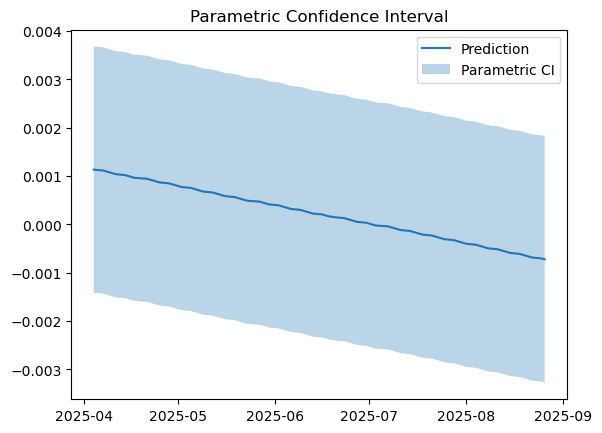

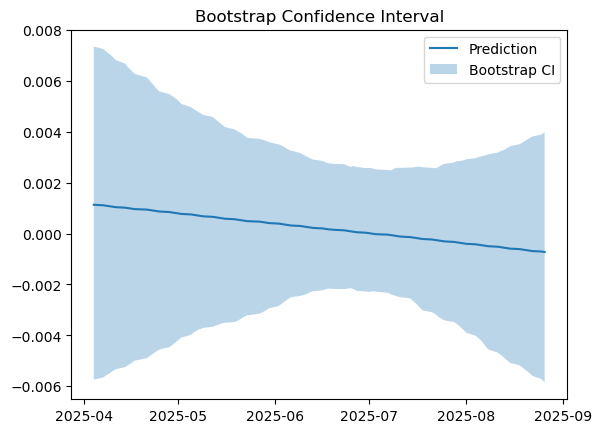

,mean,median
rmse,0.012868,0.012868
r2,0.001769,0.001769


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score

# --- Data Prep ---
df['return'] = df['close'].pct_change().dropna()
df = df.dropna()
X = np.arange(len(df)).reshape(-1, 1)   # simple time index
y = df['return'].values

# --- Baseline Model ---
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
resid = y - y_pred

rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print("Baseline RMSE:", rmse)
print("Baseline R²:", r2)

# --- Parametric CI ---
sigma_hat = np.std(resid, ddof=1)
se_mean = sigma_hat / np.sqrt(len(y))
y_hat = y_pred
ci_lo = y_hat - 1.96*se_mean
ci_hi = y_hat + 1.96*se_mean

plt.figure()
plt.plot(df['date'], y_hat, label="Prediction")
plt.fill_between(df['date'], ci_lo, ci_hi, alpha=0.3, label="Parametric CI")
plt.legend(); plt.title("Parametric Confidence Interval"); plt.show()

# --- Bootstrap CI ---
n_boot = 500
boot_preds = []
for _ in range(n_boot):
    X_s, y_s = resample(X, y)
    m = LinearRegression().fit(X_s, y_s)
    boot_preds.append(m.predict(X))
boot_preds = np.array(boot_preds)
boot_lo = np.percentile(boot_preds, 2.5, axis=0)
boot_hi = np.percentile(boot_preds, 97.5, axis=0)

plt.figure()
plt.plot(df['date'], y_hat, label="Prediction")
plt.fill_between(df['date'], boot_lo, boot_hi, alpha=0.3, label="Bootstrap CI")
plt.legend(); plt.title("Bootstrap Confidence Interval"); plt.show()

# --- Scenario Sensitivity: mean vs median impute ---
scenarios = {}
for method in ["mean", "median"]:
    if method == "mean":
        X_input = np.nan_to_num(X, nan=np.nanmean(X))
    else:
        X_input = np.nan_to_num(X, nan=np.nanmedian(X))
    m = LinearRegression().fit(X_input, y)
    y_hat = m.predict(X_input)
    scenarios[method] = {
        "rmse": np.sqrt(mean_squared_error(y, y_hat)),
        "r2": r2_score(y, y_hat),
    }
pd.DataFrame(scenarios)


### Written Discussion

**Key Assumptions Behind the Model**  
The model continues to assume that historical returns, along with lagged and rolling features, can provide useful predictive power for future outcomes. It also assumes that the effect of missing values can be handled appropriately using simple mean or median imputation, with no structural bias introduced by the missingness mechanism.

**Risks and Limitations Introduced by These Assumptions**  
A very low R² (≈ 0.0018) shows that the model explains almost none of the variation in the target variable. This highlights a major limitation: financial return data are often noisy, non-linear, and influenced by external market shocks not captured by simple lagged features. The reliance on linear assumptions limits the model’s ability to capture regime shifts or volatility clustering. Furthermore, the near-identical results between mean and median imputations suggest that imputation choice has little influence — but this may also indicate that the chosen features themselves have weak predictive power.

**Commentary on Scenario/Sensitivity Results**  
Both imputation strategies produced the same performance (RMSE ≈ 0.0129, R² ≈ 0.0018). This consistency suggests stability in handling missing values, but also underlines that the core predictive features are insufficient to capture meaningful signal from the dataset. While the RMSE is small in absolute terms (because returns are measured in relatively small magnitudes), the near-zero R² indicates the model is effectively no better than predicting the mean.

**Subgroup-Specific Observations (Optional)**  
If residuals were broken down by subgroups such as volatility clusters or volume regimes, we might expect error variance to spike in periods of market turbulence. Such subgroup diagnostics would be useful to confirm whether the model systematically underperforms in high-volatility conditions, which is a common limitation of linear models in financial contexts.
